# Prediction and Classification of Cardiac Arrhythmia using Machine Learning


## Introduction

Most cardiac disorders cause irregularities in heartbeat. These irregular patterns in rhythm of heartbeat is called Arrhythmia. Only with a quick response can the cardiac Arrhythmia be detected in patients at the critical phase. Thereby reducing the complications that might have resulted in late detection. The diagnosis of arrhythmia involves handling of huge amount of ECG data, physicians may not interpret Electrocardiogram for large datasets effectively as it is time consuming and can also cause misclassification of beats. Hence, computer assisted analysis of the ECG data using Supervised Machine Learning can play a huge role as a decision support system to the physicians.

## Objective
Implementing supervised Machine Learning Algorithms to analyze various features of electrocardiogram(ECG) details of patients. We will use publically available Cardiac Arrhythmia dataset on UCI Machine Learning Repository to develop the classification models.


## Dataset

The cardiac Arrhythmia dataset is acquired from Arrhythmia dataset in UCI repository. In this dataset, the Electrocardiogram (ECG) readings along with physical description of 452 patients. Each patient record is described by 279 attributes - 206 Linear and 73 nominal, with categorial class attribute. There are 16 classes based on value of attributes.Class are as follows:

* Class 1 - Normal
* Class 2 to 15 - Each class indicating various types of Arrhythmia.
* Class 16 - Unknowns


## Importing data and Libraries

In [ ]:
# Import the necessary libraries to implemnet it.
#!pip install tensorflow==1.14.0
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import ssl
import math
import matplotlib.pyplot as plt
import operator

from collections import defaultdict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix, classification_report, f1_score,accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D,BatchNormalization,GlobalMaxPooling1D,MaxPooling1D
from keras.regularizers import l2,l1
from keras.utils import to_categorical
# Instead of keras.optimizers, import Adam from tensorflow.keras.optimizers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [ ]:
# Import the Arrhythmia dataset from the library and replace missing values by '?'.
repo_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.data"
ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_csv(repo_url, delimiter=',', header=None,)

# Make sure the data frame has 452 rows along with 280 columns.
df.shape

(452, 280)

## Data Preprocessing
The Data Preprocessing is carried out in 3 steps:
1. **Remove unwanted columns** - Deleting the attributes having more than 40% missing values.
2. **Replace missing values** - Impute the missing values by replacing them with the attribute median.
3. **Attribute Scaling** - Normalize the attributes so that values are scaled up by processing.

NOTE: The reason to replace missing attribute values with median instead of mean is to avoid the effect of outliers for attributes with higher standard deviation.

In [ ]:
# Split the frame as Data attribute and Class
df_data = df.iloc[:,:-1]
df_class = df.iloc[:,-1]

# Replace ? by NaN
df_data = df_data.replace('?', np.NaN)

# Remove unwanted columns
# Deleting the attributes having more than 40% missing values.
thresh = len(df_data) * 0.4
df_data.dropna(thresh = thresh, axis = 1, inplace = True)

# Replace Missing values
# Imputing the remaining missing values with median of the values in the column
imp_mean = SimpleImputer(missing_values=np.NaN, strategy='median')
imputer = imp_mean.fit(df_data)
df_imp = imputer.transform(df_data)
df_data = pd.DataFrame(df_imp)

# Attribute Scaling
# Normalize the values except for the class labels for each attribute using StandardScaler.
std_scaler = StandardScaler()
x_scaled = std_scaler.fit_transform(df_data.values)
df_data = pd.DataFrame(x_scaled, index = df_data.index)

print(df_data.shape)

(452, 278)


In [ ]:
df_data.head()


,0,1,2,3,4,5,6,7,8,9,...,268,269,270,271,272,273,274,275,276,277
0,1.734439,-1.107520,0.641327,0.713814,0.135505,0.844945,0.113709,0.113809,1.201469,-1.094661,...,0.004037,0.508843,-0.013839,0.278621,-0.079546,0.0,1.109553,1.177737,0.294603,1.078670
1,0.579312,0.902918,-0.031998,-0.251644,-0.516072,0.420769,1.013301,-0.588564,-1.977064,-0.191203,...,-0.327703,0.508843,-0.157972,0.728573,-0.079546,0.0,-0.906889,0.616126,0.079613,0.504874
2,0.457720,-1.107520,0.156533,1.618932,3.197915,0.175193,0.563505,0.422853,0.464980,1.373324,...,1.994474,0.508843,0.130294,-0.471299,-0.079546,0.0,-0.618826,1.528744,-0.520878,1.057018
3,0.518516,-1.107520,0.237332,1.558590,0.721924,1.045871,0.383587,0.254284,2.054247,-0.125096,...,0.667516,0.508843,0.908612,-0.371310,-0.079546,0.0,-0.330763,0.967133,1.132324,1.739077
4,1.734439,-1.107520,0.641327,0.713814,-0.059968,0.577044,-0.216141,0.198094,0.503742,-1.094661,...,-0.161833,0.508843,1.168051,-1.071235,-0.079546,0.0,-1.771079,1.879751,0.450286,1.804035


## Split the data into train, test and validation.

Before we proceed further with building the Supervised Machine learning models, we split the model into train and test data.

Using the pre processed dataframe as input, the split is as follows:  

* Train - 70% - 316 records
* Test - 30% - 136 records

In [ ]:
# Splitting into training and testing data

X_train, X_test, Y_train, Y_test = train_test_split(df_data, df_class, test_size=0.3, shuffle = True, stratify = df_class, random_state=43)

# Splitting into training and validation data
#X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size=0.2, shuffle = True, stratify = Y_trainval, random_state=43)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(316, 278) (316,) (136, 278) (136,)


## Determining the class weights for imbalanced dataset

In [ ]:
from sklearn.utils import class_weight
# Pass classes and y as keyword arguments
class_wt = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
class_weights = dict(zip([1,2,3,4,5,6,7,8,9,10,14,15,16], class_wt))
#class_weights[0] = 0
#class_weights[11] = 0
#class_weights[12] = 0
#class_weights[13] = 0
print(class_wt.sum())
print(class_weights)

print(np.bincount(Y_train))
print(np.bincount(Y_test))

66.48389473526794
{1: 0.14215024741340532, 2: 0.7841191066997518, 3: 2.2097902097902096, 4: 2.2097902097902096, 5: 2.700854700854701, 6: 1.4298642533936652, 7: 12.153846153846153, 8: 24.307692307692307, 9: 4.051282051282051, 10: 0.6945054945054945, 14: 8.102564102564102, 15: 6.076923076923077, 16: 1.6205128205128205}
[  0 171  31  11  11   9  17   2   1   6  35   0   0   0   3   4  15]
[ 0 74 13  4  4  4  8  1  1  3 15  0  0  0  1  1  7]


## Feature Selection - Train dataset


  ### Principle Component Analysis (PCA)
  Grid search on various number of PCA components to be retained.
  
  Deciding the number of components to be selected based on the plots of:
  * Plot of Eigen values v/s No of components.
  * Plot of Percent of cumulative variance v/s No of components.

Based on the plots select all the components with eigen value greater than or equal to 1 (Rule of Thumb).



Components from Feature selection using PCA (Having Eigen values >=1)- 88

Feature Selection using PCA complete for the train data.




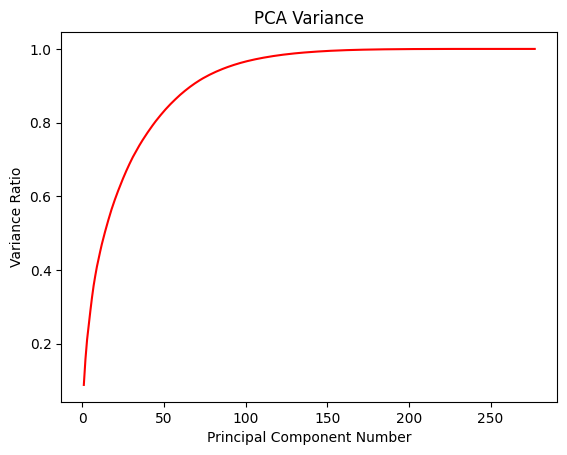

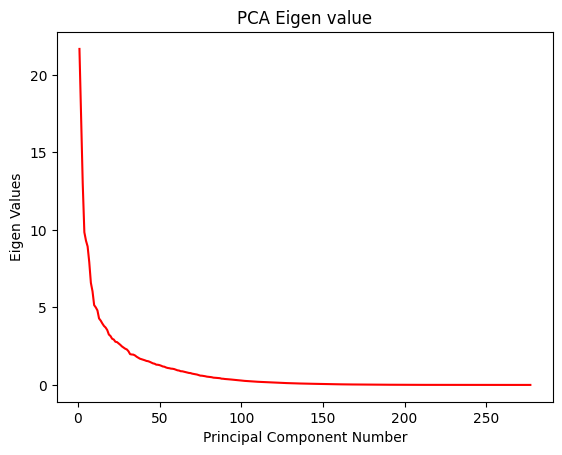

In [ ]:
# Implementation of PCA
pca_dict = {}
eigen_dict = {}
for n_comp in df_data.columns:
  pca = PCA(n_components=n_comp)
  temp_train_pca = pca.fit_transform(X_train)
  temp_test_pca = pca.transform(X_test)
  eigen_values = pca.explained_variance_[:n_comp]

  if n_comp > 0:
    #print (n_comp,pca.explained_variance_ratio_.sum(),eigen_values)[-1])
    pca_dict[n_comp] = pca.explained_variance_ratio_.sum()
    eigen_dict[n_comp] = eigen_values[-1]

f = plt.figure(1)
f.patch.set_facecolor('white')
plt.title('PCA Variance')
plt.xlabel('Principal Component Number')
plt.ylabel('Variance Ratio')
plt.plot(list(pca_dict.keys()),list(pca_dict.values()),'r')
f.show()

g = plt.figure(2)
g.patch.set_facecolor('white')
plt.title('PCA Eigen value')
plt.xlabel('Principal Component Number')
plt.ylabel('Eigen Values')
plt.plot(list(eigen_dict.keys()),list(eigen_dict.values()),'r')
g.show()

# Selecting components with Eigen value greater than 1 from the list
#pca_comp_eigen = max([key for key,val in eigen_dict.items() if val >= 1])
pca_comp_eigen = max([key for key,val in pca_dict.items() if val < 0.95])

print('Components from Feature selection using PCA (Having Eigen values >=1)- ' + str(pca_comp_eigen) + '\n')

# Performing PCA for the train data with the fixed components
pca = PCA(n_components=pca_comp_eigen)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print('Feature Selection using PCA complete for the train data.\n\n')

### Random Forest Classifier

This model works on a portion of training dataset by continuously sampling with replacement. Then fitting a decision tree to the model. Each decision tree is a sequence of yes-no questions based on a single or combination of features. All the features are not considered by the tree, which conirms that individual decision trees are not corelated. Hence the classifier less prone to overfitting.

The measure of impurity is by Gini index .


In [ ]:
# Implementation for Random forest
rfc = SelectFromModel(RandomForestClassifier(n_estimators = 20, random_state=0, n_jobs = -1))
rfc.fit(X_train, Y_train)

rfc_comp = X_train.columns[(rfc.get_support())]
print("Components from Feature Selection using Random Forest Classifier - ",len(rfc_comp))

# Transform the model to contain only the new data.
X_train_rfc= rfc.transform(X_train)
X_test_rfc = rfc.transform(X_test)
# Confirm that the transformed model has reduced components only
print(len(X_train_rfc[0]), len(X_test_rfc[0]))

Components from Feature Selection using Random Forest Classifier -  99
99 99


### Support Vector Machines

Support Vector Machines(SVM) is a supervised machine learning algorithm used for classification, clustering and regression.

An SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible.New examples are then mapped into that same space and predicted to belong to a category based on the side of the gap on which they fall.

Below is the implementaion of SVM by tuning the model on hyperparameters:  
* Kernal type - linear, rbf, poly and sigmoid.
* Scale of regularization parameters - 10^-3, 10^-2, 10^-1, 10^0, 10^1, 10^2, 10^3.


### **SVM implementation using PCA** :
Below is the SVM model implementations of different types of SVM (linear, rbf and kernel) for classification of arrhythmia for the features selected by Principal Component Analysis (PCA). We will be comparing the accuracy scores of these SVM types to decide which one is better.

SVM Accuracies - PCA: 
Linear kernal has maximum accuracy - 0.7353 for critical factor 0.01

Radial Basis Function Kernel SVM accuracy - 0.6618 for critical factor 100

Polynomial Kernel SVM has maximum accuracy - 0.6838 for critical factor 1000

Sigmoid Kernel SVM has maximum accuracy - 0.6985 for critical factor 1




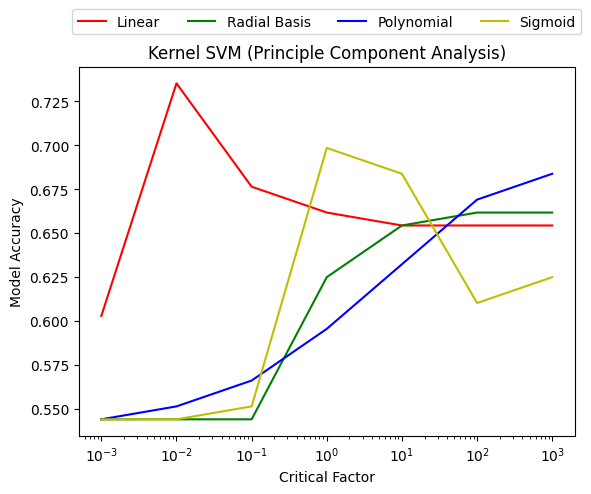

In [ ]:
# Hyperaeter tuning on regularization parameter and kernal for SVM
c_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
kernals = ['linear','rbf','poly','sigmoid']

pca_accuracy = {'linear':[], 'rbf':[], 'poly':[], 'sigmoid':[]}
#pca_f1_score = {'linear':[], 'rbf':[], 'poly':[], 'sigmoid':[]}

for kernal in kernals:
  for cval in c_list:

    clf = SVC(max_iter=100000, kernel=kernal, C=cval)

    clf.fit(X_train_pca, Y_train)
    pca_accuracy[kernal].append(clf.score(X_test_pca, Y_test))
    yPred = clf.predict(X_test_pca)
    #pca_f1_score[kernal].append(f1_score(Y_test, yPred, average='weighted'))

    del clf
    del yPred

print('SVM Accuracies - PCA: ')
print('Linear kernal has maximum accuracy - '+ str(round(max(pca_accuracy['linear']),4)) + ' for critical factor ' + str(c_list[pca_accuracy['linear'].index(max(pca_accuracy['linear']))]) )
print('\nRadial Basis Function Kernel SVM accuracy - '+ str(round(max(pca_accuracy['rbf']),4)) + ' for critical factor ' + str(c_list[pca_accuracy['rbf'].index(max(pca_accuracy['rbf']))]) )
print('\nPolynomial Kernel SVM has maximum accuracy - ' + str(round(max(pca_accuracy['poly']),4)) + ' for critical factor ' + str(c_list[pca_accuracy['poly'].index(max(pca_accuracy['poly']))]))
print('\nSigmoid Kernel SVM has maximum accuracy - ' + str(round(max(pca_accuracy['sigmoid']),4)) + ' for critical factor ' + str(c_list[pca_accuracy['sigmoid'].index(max(pca_accuracy['sigmoid']))]) +'\n\n')

# Plot the Accuracy with C values
fig = plt.figure(1)
fig.patch.set_facecolor('white')
plt.xscale('log')
plt.title('Kernel SVM (Principle Component Analysis)')
plt.xlabel('Critical Factor')
plt.ylabel('Model Accuracy')
plt.plot(c_list, pca_accuracy['linear'], 'r', label = 'Linear')
plt.plot(c_list, pca_accuracy['rbf'], 'g', label = 'Radial Basis')
plt.plot(c_list, pca_accuracy['poly'], 'b', label = 'Polynomial')
plt.plot(c_list, pca_accuracy['sigmoid'], 'y', label = 'Sigmoid')
plt.legend(bbox_to_anchor = (0., 1.02, 1., .202), loc = 10, ncol=4, borderaxespad = 0)
fig.show()



####**SVM implementation using Random Forest Classifier**
Below is the SVM model implementations of different types of SVM (linear, rbf and kernel) for classification of arrhythmia for the features selected by Random Forests. We will be comparing the accuracy scores of these SVM types to decide which one is better.

In [1]:
# Hyperaeter tuning on regularization parameter and kernal for SVM
c_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
kernals = ['linear','rbf','poly','sigmoid']

rfc_accuracy = {'linear':[], 'rbf':[], 'poly':[], 'sigmoid':[]}
#rfc_f1_score = {'linear':[], 'rbf':[], 'poly':[], 'sigmoid':[]}

for kernal in kernals:
  for cval in c_list:

    clf = SVC(max_iter=100000, kernel=kernal, C=cval)

    clf.fit(X_train_rfc, Y_train)
    rfc_accuracy[kernal].append(clf.score(X_test_rfc, Y_test))
    yPred = clf.predict(X_test_rfc)
    #pca_f1_score[kernal].append(f1_score(Y_test, yPred, average='weighted'))

    del clf
    del yPred

print('SVM Accuracies - Random Forest Classifier: ')
print('Linear kernal has maximum accuracy - '+ str(round(max(rfc_accuracy['linear']),4)) + ' for critical factor ' + str(c_list[rfc_accuracy['linear'].index(max(rfc_accuracy['linear']))]) )
print('\nRadial Basis Function Kernel SVM accuracy - '+ str(round(max(rfc_accuracy['rbf']),4)) + ' for critical factor ' + str(c_list[rfc_accuracy['rbf'].index(max(rfc_accuracy['rbf']))]) )
print('\nPolynomial Kernel SVM has maximum accuracy - ' + str(round(max(rfc_accuracy['poly']),4)) + ' for critical factor ' + str(c_list[rfc_accuracy['poly'].index(max(rfc_accuracy['poly']))]))
print('\nSigmoid Kernel SVM has maximum accuracy - ' + str(round(max(rfc_accuracy['sigmoid']),4)) + ' for critical factor ' + str(c_list[rfc_accuracy['sigmoid'].index(max(rfc_accuracy['sigmoid']))]) +'\n\n')

# Plot the Accuracy with C values
fig = plt.figure(1)
fig.patch.set_facecolor('white')
plt.xscale('log')
plt.title('Kernal SVM (Random Forest Classifier)')
plt.xlabel('Critical Factor')
plt.ylabel('Model Accuracy')
plt.plot(c_list, rfc_accuracy['linear'], 'r', label = 'Linear')
plt.plot(c_list, rfc_accuracy['rbf'], 'g', label = 'Radial Basis')
plt.plot(c_list, rfc_accuracy['poly'], 'b', label = 'Polynomial')
plt.plot(c_list, rfc_accuracy['sigmoid'], 'y', label = 'Sigmoid')
plt.legend(bbox_to_anchor = (0., 1.02, 1., .202), loc = 10, ncol=4, borderaxespad = 0)
fig.show()

NameError: name 'SVC' is not defined

### Best SVM model

Feature Selection - PCA and Random forest - equally good  
SVM Kernel - Linear SVM  
Regularization parameter - 10^-1

In [ ]:
#Assign the best values for the SVM parameter
clf = SVC(max_iter=100000, kernel='linear', C=0.01)

clf.fit(X_train_pca, Y_train)

yPred_svm = clf.predict(X_test_pca)

acc = accuracy_score(yPred_svm,Y_test)
print('Accuracy for SVM - Linear Kernal - ',round(acc,4))

result = classification_report(Y_test, yPred_svm)
print("\n",result)

Accuracy for SVM - Linear Kernal -  0.7353

               precision    recall  f1-score   support

           1       0.70      0.96      0.81        74
           2       0.75      0.69      0.72        13
           3       1.00      1.00      1.00         4
           4       0.60      0.75      0.67         4
           5       1.00      0.25      0.40         4
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       1.00      0.67      0.80         3
          10       1.00      0.67      0.80        15
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         7

    accuracy                           0.74       136
   macro avg       0.47      0.38      0.40       136
weighted avg       0.66      0.74      0.68       136



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Compute Confusion matrix and accuracy score
print('Accuracy of Weighted MLP model - ',round(accuracy_score(list(Y_test),Ypred),4))
cm = confusion_matrix(list(Y_test), Ypred)
print('\nClassification Report for model\n',classification_report(list(Y_test),Ypred))

#saving the predictions and probabilities to the Shared directory
np.save('ypred_mlp_probs_0.6691.npy', Ypred)
!cp *.npy /content/drive/Shared\ drives/ALDA\ Project/ClassWeights/

Accuracy of Weighted MLP model -  0.6691

Classification Report for model
               precision    recall  f1-score   support

           1       0.74      0.85      0.79        74
           2       0.40      0.46      0.43        13
           3       0.80      1.00      0.89         4
           4       0.75      0.75      0.75         4
           5       0.67      0.50      0.57         4
           6       0.43      0.38      0.40         8
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       1.00      0.67      0.80         3
          10       0.75      0.40      0.52        15
          14       1.00      1.00      1.00         1
          15       0.50      1.00      0.67         1
          16       0.00      0.00      0.00         7

    accuracy                           0.67       136
   macro avg       0.54      0.54      0.52       136
weighted avg       0.65      0.67      0.65       136



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
